In [43]:
import os
import numpy
from matplotlib import pyplot
from numpy.random import default_rng
from scipy.stats import wasserstein_distance
import matplotlib
import matplotlib.pyplot as plt
import Bio
import Bio.SeqRecord
import Bio.SeqIO
import pygtrie
import re


def get_fragment_indices(fragment, min_length):
    while True:
        indices_count = fragment.shape[0]
        start_index = numpy.random.randint(indices_count)
        for end_index in range(start_index, indices_count):
            if fragment[end_index] - fragment[start_index] > min_length:
                indices = numpy.array(list(range(start_index, end_index+1)))
                return indices


def match_fragments(full_fragment, partial_fragment):
    full_fragment_length = numpy.max(full_fragment)
    partial_fragment_length = numpy.max(partial_fragment)
    start_pos = 0
    end_pos = partial_fragment_length
    delta = 0.00001
    max_dist = numpy.inf
    matched_indices = None
    x = []
    y = []
    while end_pos < 1:
        # indices = numpy.where(numpy.any((full_fragment > start_pos) and (full_fragment < end_pos)))
        # indices = numpy.where(numpy.any(full_fragment > start_pos))
        index_predicates = (full_fragment > start_pos) & (full_fragment < end_pos)
        indices = numpy.where(index_predicates)[0]
        indices.sort()

        current_fragment = full_fragment[indices]
        current_fragment = current_fragment - current_fragment[0]

        dist = wasserstein_distance(current_fragment, partial_fragment)
        x.append(start_pos)
        y.append(dist)
        if dist < max_dist:
            max_dist = dist
            matched_indices = indices

        end_pos = end_pos + delta
        start_pos = start_pos + delta

    return matched_indices, numpy.array(x), numpy.array(y)


def dye_chromosome(chromosome: Bio.SeqRecord.SeqRecord, fluorochrome: str):
    chromosome = chromosome.lower()
    fluorochrome = fluorochrome.lower()
    chromosome_str = str(chromosome.seq)
    indices = [m.start() for m in re.finditer(fluorochrome, chromosome_str)]
    fragment = numpy.array(indices).astype(float) / float(len(chromosome_str))
    return indices, fragment

In [44]:
filename = os.path.normpath("C:/genome/GCA_000001405.29_GRCh38.p14_genomic.fna")
seq_dict = {rec.id: rec for rec in Bio.SeqIO.parse(filename, "fasta")}
chromosome4 = seq_dict['CM000666.2']
chromosome4_segment = chromosome4[88227200:88704008]
chromosome4_segment_len = len(chromosome4_segment.seq)
print(f'chromosome4_segment length: {chromosome4_segment_len}')
full_fragment_indices, full_fragment = dye_chromosome(chromosome=chromosome4_segment, fluorochrome='CTTAAG')

# size = 100
# rng = default_rng(seed=0)
# full_fragment = rng.uniform(size=size)
# full_fragment.sort()
#

partial_fragment_indices = get_fragment_indices(fragment=full_fragment, min_length=0.1)
partial_fragment = full_fragment[partial_fragment_indices]

sampling_factor = 0.9
sampled_partial_fragment_size = int(partial_fragment_indices.shape[0] * sampling_factor)
sampled_partial_fragment_meta_indices = numpy.random.choice(partial_fragment_indices.shape[0], sampled_partial_fragment_size, replace=False)
sampled_partial_fragment_meta_indices.sort()

sampled_partial_fragment_indices = partial_fragment_indices[sampled_partial_fragment_meta_indices]
sampled_partial_fragment = full_fragment[sampled_partial_fragment_indices]
sampled_partial_fragment.sort()

min_scale = 0.95
max_scale = 1.05
scale = (max_scale - min_scale) * numpy.random.random(1) + min_scale
# scale = 1

transformed_sampled_partial_fragment = scale * (sampled_partial_fragment - sampled_partial_fragment[0])

mu, sigma = 0, 0.001 # mean and standard deviation
noise = numpy.random.normal(mu, sigma, transformed_sampled_partial_fragment.shape[0])
print(f'noise: {noise}')
print(f'noise (bases): {noise * chromosome4_segment_len}')

transformed_noised_sampled_partial_fragment = transformed_sampled_partial_fragment + noise

print(f'full fragment length: {full_fragment.shape[0]}')
print(f'partial fragment length: {transformed_sampled_partial_fragment.shape[0]}')

matched_indices, x_pos, y_dist = match_fragments(full_fragment=full_fragment, partial_fragment=transformed_noised_sampled_partial_fragment)

# matched_indices, x_pos, y_dist = match_fragments(full_fragment=full_fragment, partial_fragment=partial_fragment)
matched_fragment = full_fragment[matched_indices]

print(f'matched indices: {matched_indices}')
print(f'partial fragment indices: {partial_fragment_indices}')

chromosome4_segment length: 476808
noise: [-0.00071292  0.00026538 -0.00124979  0.00015521  0.00173831  0.00017839
  0.00056122 -0.00041744  0.00107894  0.00115873  0.00060215 -0.00048264
 -0.00136578 -0.00053647  0.00058007  0.0005601 ]
noise (bases): [-339.92715525  126.53403814 -595.90762383   74.00668379  828.84188529
   85.05666305  267.59492846 -199.03892919  514.44609808  552.49405837
  287.11007414 -230.12627274 -651.21316498 -255.79551217  276.580566
  267.0586161 ]
full fragment length: 134
partial fragment length: 16
matched indices: [66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84]
partial fragment indices: [66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83]


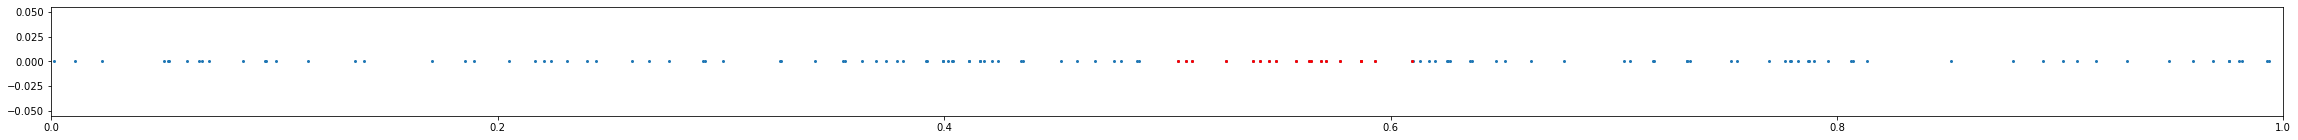

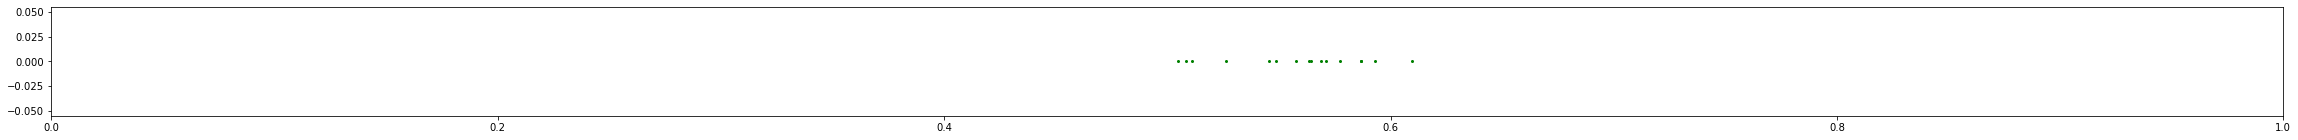

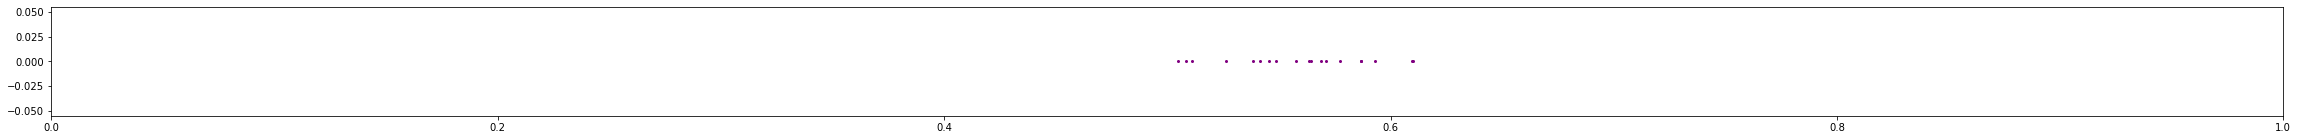

(0.0, 1.0)

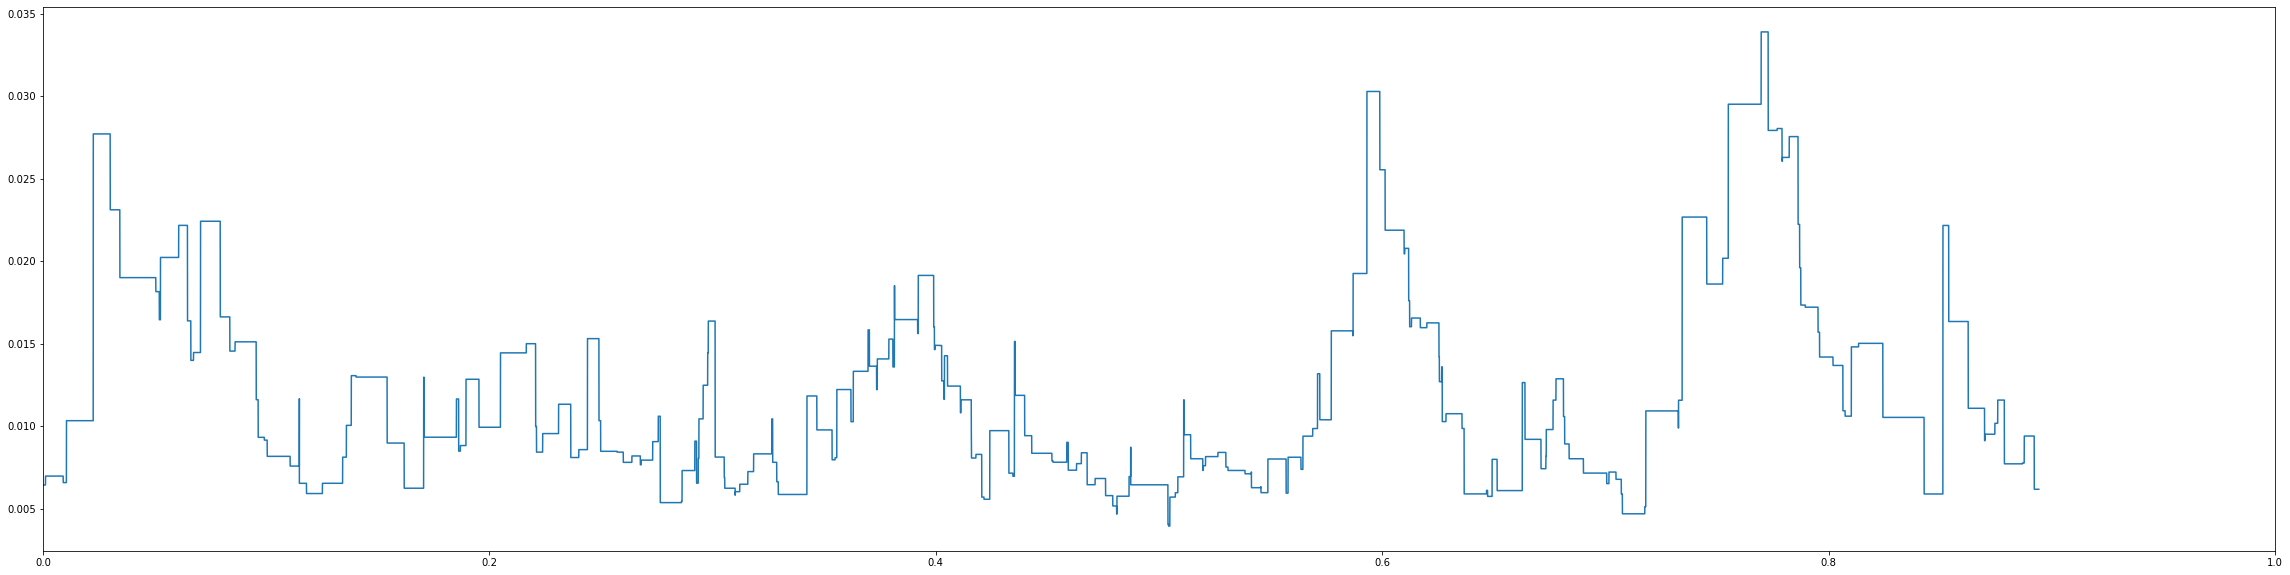

In [45]:
plt.figure(figsize=(40,2))
y1 = numpy.zeros_like(full_fragment)
x1 = full_fragment
plt.plot(x1, y1, 'o', markersize=2)

y2 = numpy.zeros_like(partial_fragment)
x2 = partial_fragment
plt.plot(x2, y2, 'o', markersize=2, markerfacecolor='red', markeredgecolor='red')

# y3 = numpy.zeros_like(sampled_partial_fragment)
# x3 = sampled_partial_fragment
# plt.plot(x3, y3, 'o', markersize=2, markerfacecolor='green', markeredgecolor='green')
plt.xlim(0, 1)
plt.show()

plt.figure(figsize=(40,2))
y3 = numpy.zeros_like(sampled_partial_fragment)
x3 = sampled_partial_fragment
plt.plot(x3, y3, 'o', markersize=2, markerfacecolor='green', markeredgecolor='green')
plt.xlim(0, 1)
plt.show()

plt.figure(figsize=(40,2))
y4 = numpy.zeros_like(matched_fragment)
x4 = matched_fragment
plt.plot(x4, y4, 'o', markersize=2, markerfacecolor='purple', markeredgecolor='purple')
plt.xlim(0, 1)
plt.show()


plt.figure(figsize=(40, 10))
plt.plot(x_pos, y_dist, '-', markersize=2)
plt.xlim(0, 1)